In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
print(tf.__version__)


2.2.0


In [36]:
train_df=pd.read_csv('train.csv').fillna(' ')
train_df.sample(10)

,comment_text,toxic
65022,Ebyabe falsifies information on her repeated b...,0
107065,"Until you have an attitude like this, you will...",0
37063,""" | decline=The page has already been deleted....",0
133101,Thanks for the advice \n\nThank you for taking...,0
49714,"Just as a Side note, The splinter group Sunder...",0
100094,How do you get semen stains off jeans?\nHow do...,1
91732,""". Because of you and your IPs keep changing a...",0
3393,"""\n\n Please stop. If you continue to vandaliz...",0
142223,Dickhead\n\nDon't be a dick and add stupid and...,1
155061,Reference \n\nFor Jews not walking under the A...,0


In [37]:
x=train_df['comment_text'].values
print(x)


["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."
 ...
 'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.'
 'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.'
 '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of community goes ""you have bad ideas"" go away, instead o

In [38]:
train_df.loc[train_df['toxic']==1].sample(10)

,comment_text,toxic
143133,fuck off you son of a bitch!!,1
70641,I also find it interesting that after TXmaster...,1
157428,Ok.... \n\nBitch i swear to God i will fuckin ...,1
38512,Let's get to fuckin big daddy ==\nMan I love s...,1
88813,Dedicate time? go ahead delete the stupid thin...,1
137211,"If you think you are clever, you make a big mi...",1
82092,you will be reported as a racist \n\n you are ...,1
120268,I dont care about your note fuck you. I will n...,1
125117,Robin hood is a gay bum bandit who abuses wome...,1
38388,"If you want to stop being called a honcho, the...",1


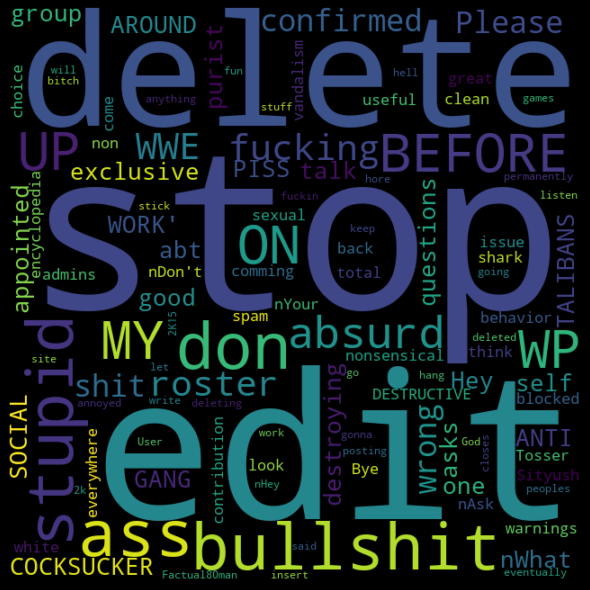

In [39]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
comments = train_df['comment_text'].loc[train_df['toxic']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [40]:
y=train_df['toxic'].values
print(y)

[0 0 0 ... 0 0 0]


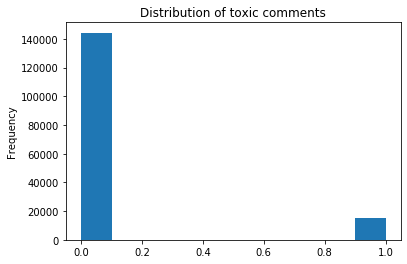

In [41]:
train_df['toxic'].plot(kind='hist', title='Distribution of toxic comments')

In [42]:
train_df['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [43]:
max_features=20000
max_text_length=400

In [44]:
x_tokenizer=text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenized=x_tokenizer.texts_to_sequences(x)
x_train_val=sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

In [45]:
embedding_dim=100
embeddings_index=dict()
f=open('glove.6B.100d.txt')
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:], dtype='float32')
    embeddings_index[word]=coefs
f.close()
print(f'Found{len(embeddings_index)} word vectors.')


Found400000 word vectors.


In [46]:
embedding_matrix=np.zeros((max_features, embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index>max_features -1:
        break
    else:
        embedding_vector=embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index]=embedding_vector
            
            

In [47]:
model=Sequential()
model.add(Embedding(max_features, embedding_dim, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), trainable=False))
model.add(Dropout(0.2))

In [48]:
filters=250
kernel_size=3
hidden_dims=250


In [49]:
model.add(Conv1D(filters, kernel_size, padding='valid'))
model.add(MaxPooling1D())               
model.add(Conv1D(filters, 5,  padding='valid', activation='relu'))                                             
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         2000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 250)         75250     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 250)         0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)              

ValueError: Input 0 of layer conv1d_7 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 250]

In [50]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
x_train, x_val, y_train, y_val=train_test_split(x_train_val, y, test_size=0.15, random_state=1)

In [52]:
batch_size=32
epochs=3

model.fit(x_train, y_train, batch_size+batch_size,
         epochs=3, validation_data=(x_val, y_val))

Epoch 1/3
2120/2120 [==============================] - 64s 30ms/step - loss: 0.1541 - accuracy: 0.9445 - val_loss: 0.1303 - val_accuracy: 0.9502
Epoch 2/3
2120/2120 [==============================] - 64s 30ms/step - loss: 0.1303 - accuracy: 0.9519 - val_loss: 0.1297 - val_accuracy: 0.9510
Epoch 3/3
2120/2120 [==============================] - 64s 30ms/step - loss: 0.1202 - accuracy: 0.9550 - val_loss: 0.1309 - val_accuracy: 0.9553


In [53]:
test_df=pd.read_csv('test.csv')

In [54]:
x_test=test_df['comment_text'].values

In [55]:
x_test_tokenized=x_tokenizer.texts_to_sequences(x_test)
x_testing=sequence.pad_sequences(x_test_tokenized, maxlen=max_text_length)

In [56]:
y_testing=model.predict(x_testing, verbose=1, batch_size=32)

4787/4787 [==============================] - 35s 7ms/step


In [58]:
y_testing.shape

(153164, 1)

In [59]:
y_testing[0]


array([0.9883031], dtype=float32)

In [61]:
test_df['Toxic']=['not toxic' if x<.5 else 'toxic' for x in y_testing]
test_df[['comment_text', 'Toxic']].head(20)

,comment_text,Toxic
0,Yo bitch Ja Rule is more succesful then you'll...,toxic
1,== From RfC == \n\n The title is fine as it is...,not toxic
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",not toxic
3,":If you have a look back at the source, the in...",not toxic
4,I don't anonymously edit articles at all.,not toxic
5,Thank you for understanding. I think very high...,not toxic
6,Please do not add nonsense to Wikipedia. Such ...,not toxic
7,:Dear god this site is horrible.,not toxic
8,""" \n Only a fool can believe in such numbers. ...",not toxic
9,== Double Redirects == \n\n When fixing double...,not toxic
